<a href="https://colab.research.google.com/github/czeacach/fashion_designers/blob/main/wdt_spatialisation_lieux_d'%C3%A9tudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatialisation des naissances: analyse des données

## Introduction
Dans ce carnet nous expérimentons différentes méthodes de spatialisation de l'information:

* la projection de points avec diamètre de longueur proportionnelle à l'effectif des objets représentés

* la représentation de polygones correspondants aux États contemporains avec gradient de couleur en fonction de l'effectif des individus nés dans cette région: cartes choroplèthes

* un affichage dynamique de l'évolution dans le temps utilisant la librairie Plotly Express


## Les SIG
L’information géographique (attributs, relations spatiales, géométries)
Les systèmes d'information géographique ou SIG : formes des géométries (du point à la 3D)
Représentation de la réalité spatiale: géométries et données attributaires
Exemple: Corine Land Cover, base de données européenne d'occupation du sol, financée par la communauté européenne

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
### Noter qu'il faudra avoir installé toutes les librairies nécessaires
# dans l'environnement conda utilisé pour exécuter ce carnet
import pandas as pd
import geopandas as gpd
#from shapely.geometry import LineString
from geopandas.tools import sjoin
#import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
#import seaborn as sns
import json
import IPython

In [88]:
### Librairies déjà installées avec Python
import pprint
import sqlite3 as sql
import sys
from importlib import reload
!pip install geodatasets
!pip install itables

In [89]:
from geodatasets import get_path
from itables import init_notebook_mode, show
import os

## Un premier affichage exploratoire
On utilise la librairie GeoPandas qui apporte de nombreuses fonctionnalités SIG

**Introduction à GeoPandas**

Noter que les données de Wikidata sont stockées au format WKT (Well Known Text), par ex. POINT (37.61778 55.75583), et que la librairie GeoPanas va les transformer en géométries (type de valeur Python spécifique)

### Se connecter à la base de données

In [90]:
# Chemin de la base de données dans Google Drive
db_path = "/content/drive/MyDrive/dossier de travail/fashion_designers_data_analysis.db"

# Connexion à la base de données SQLite
cn = sql.connect(db_path)
cn

In [91]:
### Préparer les données à afficher
# Il est plus simple d'effecture cette requête en SQL que dans Pandas
cur = cn.cursor()
l = cur.execute("""
SELECT organisation, organisationLabel, COUNT(*) eff, MAX(coordinates) geo_coord
FROM wdt_place_study
-- il y a des erreurs dans Wikidata
WHERE coordinates LIKE 'Point(%'
GROUP BY organisation, organisationLabel
-- exclut les valeurs vides
HAVING LENGTH(MAX(coordinates)) > 7
ORDER BY eff DESC
""").fetchall()
print(len(l))
l[:2]

1069


[('http://www.wikidata.org/entity/Q1339626',
  'Parsons School of Design',
  68,
  'Point(-73.994166666 40.735277777)'),
 ('http://www.wikidata.org/entity/Q1053996',
  'Central Saint Martins',
  56,
  'Point(-0.125 51.535555555)')]

In [92]:
### Créer un dataframe contenant le résultat
df_l = pd.DataFrame(l, columns=['placeUri', 'placeLabel', 'effectif', 'geoCoord'])
df_l.head()

,placeUri,placeLabel,effectif,geoCoord
0,http://www.wikidata.org/entity/Q1339626,Parsons School of Design,68,Point(-73.994166666 40.735277777)
1,http://www.wikidata.org/entity/Q1053996,Central Saint Martins,56,Point(-0.125 51.535555555)
2,http://www.wikidata.org/entity/Q844999,Fashion Institute of Technology,52,Point(-73.994166666 40.746666666)
3,http://www.wikidata.org/entity/Q1753535,Royal College of Art,27,Point(-0.178888888 51.501388888)
4,http://www.wikidata.org/entity/Q2746779,Royal Academy of Fine Arts,25,Point(4.4069 51.2234)


In [93]:
### Tester la fonction qui exécute la conversion en géométrie
# Cf. excursus concernant le nettoyage ci-dessous
s = gpd.GeoSeries.from_wkt(df_l.geoCoord[:5])
s

0    POINT (-73.99417 40.73528)
1     POINT (-0.12500 51.53556)
2    POINT (-73.99417 40.74667)
3     POINT (-0.17889 51.50139)
4      POINT (4.40690 51.22340)
dtype: geometry

In [94]:
### Créer un dataframe geopandas avec une colonne contenant une géométrie
# https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
study_gdf = gpd.GeoDataFrame(
    df_l[['placeUri', 'placeLabel', 'effectif']],\
    geometry=gpd.GeoSeries.from_wkt(df_l.geoCoord.to_list()), crs="EPSG:4326"
)

# On dispose ainsi du DataFrame GeoPandas avec la colonne indispensable 'geometry'
study_gdf.head(3)

,placeUri,placeLabel,effectif,geometry
0,http://www.wikidata.org/entity/Q1339626,Parsons School of Design,68,POINT (-73.99417 40.73528)
1,http://www.wikidata.org/entity/Q1053996,Central Saint Martins,56,POINT (-0.12500 51.53556)
2,http://www.wikidata.org/entity/Q844999,Fashion Institute of Technology,52,POINT (-73.99417 40.74667)


## Réalisation de la première carte

In [95]:
### Inspection des données à afficher
study_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   placeUri    1069 non-null   object  
 1   placeLabel  1069 non-null   object  
 2   effectif    1069 non-null   int64   
 3   geometry    1069 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 33.5+ KB


In [96]:
### Datasets Geopandas pour la couche de base
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [97]:
### Récupérer la carte de base, qui est aussi un DataFrame GeoPandas
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
world.head()

<ipython-input-97-9ef4baaeec50>:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### La question du géoréférencement des géométries
Le géoide
Le système géodésique
Le système géodésique mondial WGS 84


In [98]:
### Types de géométries
pprint.pp(world.crs)
print('-------\n')
pprint.pp(study_gdf.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

-------

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



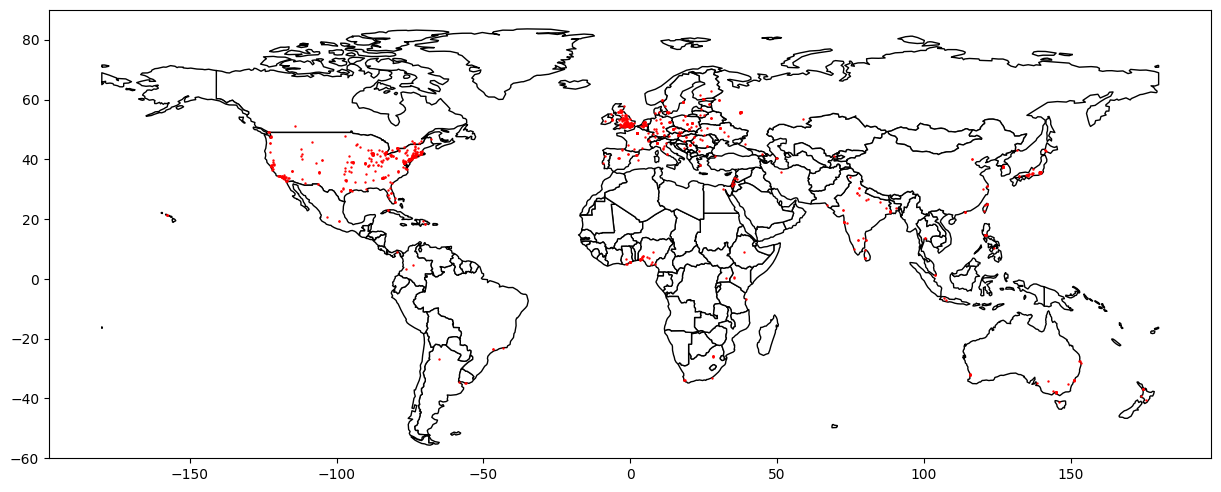

In [99]:
### Cartographier de toutes les lieux d'études de personnes
# projection géographique

ax = world.plot(color="white", edgecolor="black", figsize=(15,10))

#ax.set_xlim([-0.1, 2])
ax.set_ylim([-60, 90])

# Noter que le diamètre du marqueur est fixe
study_gdf.plot(ax=ax, color="red", markersize=0.5)

plt.show()

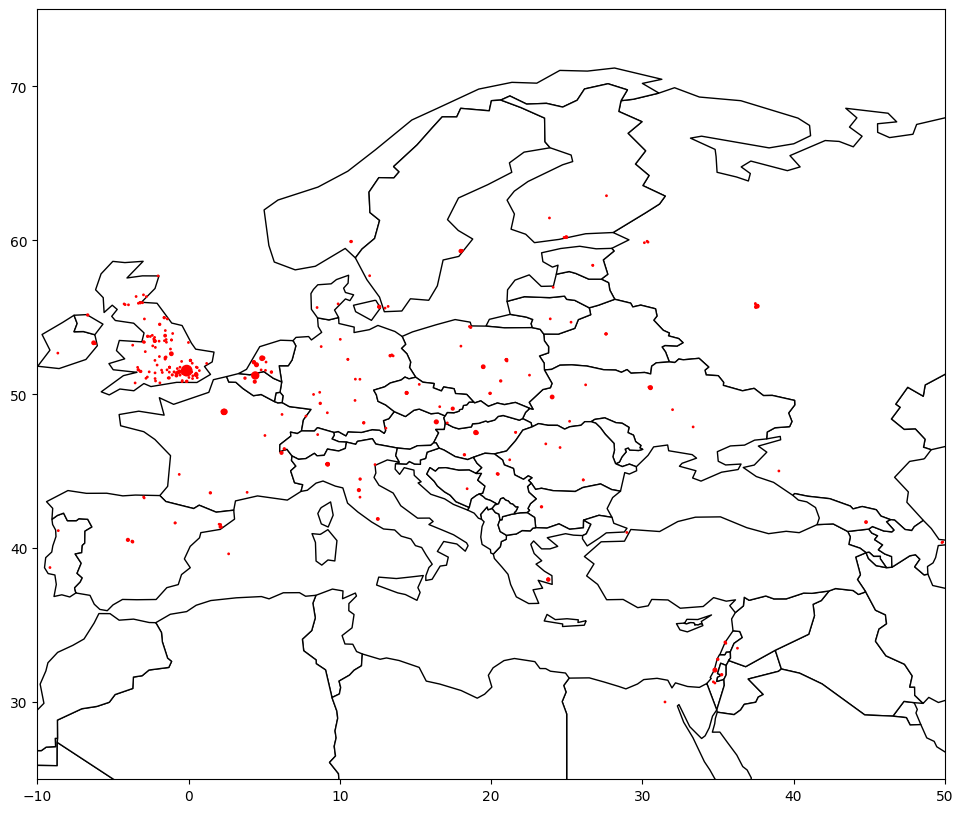

In [100]:
### Focus sur l'Europe à partir de la même carte
# On restreint les degrés longitude, latitude

ax = world.plot(color="white", edgecolor="black", figsize=(15,10))

# lon
ax.set_xlim([-10, 50])
# lat
ax.set_ylim([25, 75])

# Noter que le diamètre du marqueur est proportionnel aux effectifs du lieu
study_gdf.plot(ax=ax, color="red", markersize=study_gdf.effectif)

plt.show()

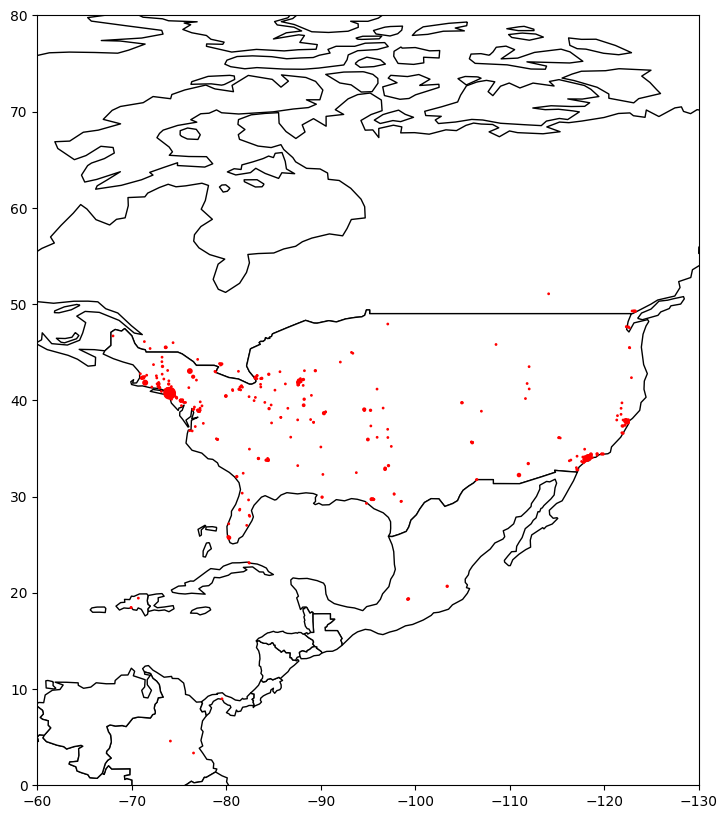

In [101]:
### Focus sur les Etats-Unis
# On restreint les degrés longitude, latitude

ax = world.plot(color="white", edgecolor="black", figsize=(15,10))

# lon
ax.set_xlim([-60, -130])
# lat
ax.set_ylim([0, 80])

# Noter que le diamètre du marqueur est proportionnel aux effectifs du lieu
study_gdf.plot(ax=ax, color="red", markersize=study_gdf.effectif)

plt.show()

In [102]:
### Transformation de la géographie
# vers une géométrie projetée: Web Mercator (EPSG 3857)
# Google Maps Global Mercator (EPGS 900913)

## Démarche effectuée à titre illustratif ici:
# indispensable si on utilise des données spatiales nationales
# qui sont dans des coordonnées et projections spatiales propres



### https://en.wikipedia.org/wiki/Web_Mercator_projection

prj_world = world.copy(deep=True)
prj_world.geometry = prj_world.geometry.to_crs(900913)
pprint.pp(prj_world.crs)
print('------')
prj_study_gdf = study_gdf.copy(deep=True)
prj_study_gdf.geometry = prj_study_gdf.geometry.to_crs(900913)
pprint.pp(prj_study_gdf.crs)

<Projected CRS: EPSG:900913>
Name: Google Maps Global Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

------
<Projected CRS: EPSG:900913>
Name: Google Maps Global Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



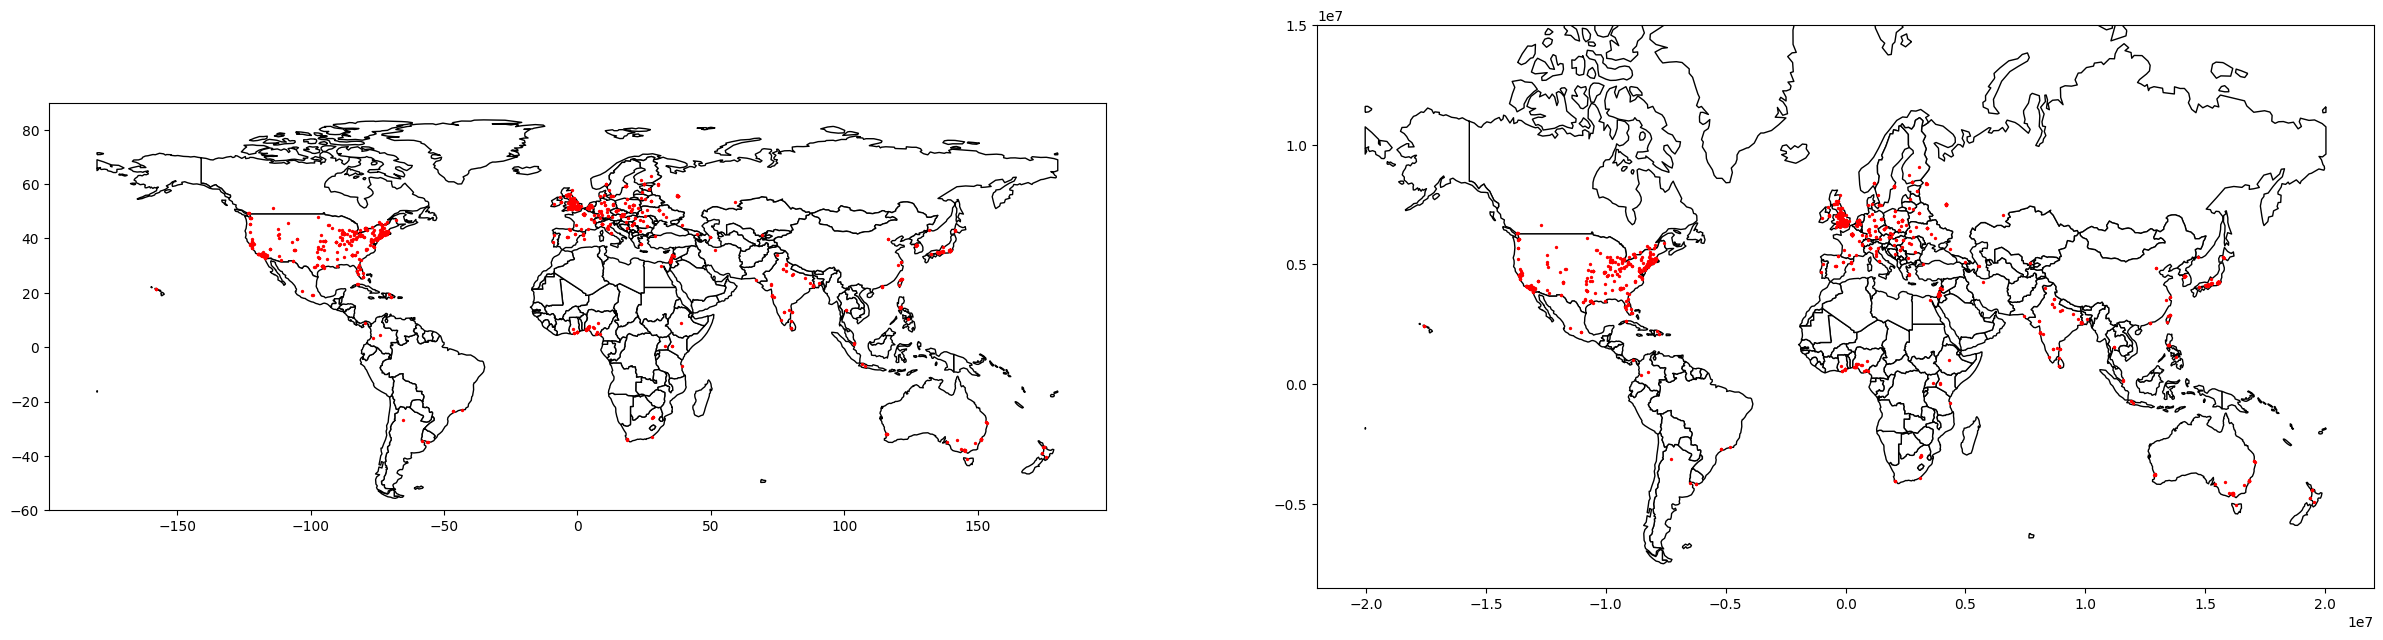

In [103]:
### Cartographier tous les lieux d'études des personnes
# avec deux systèmes de projection différents:
# géographique à gauche, Global Mercator à droite

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,20))

ax1 = world.plot(color="white", ax=axes[0], edgecolor="black")
#ax.set_xlim([-0.1, 2])
ax1.set_ylim([-60, 90])

study_gdf.plot(ax=axes[0], color="red", markersize=2)

ax2 = prj_world.plot(color="white", ax=axes[1], edgecolor="black")
#ax.set_xlim([-0.1, 2])
ax2.set_ylim([-8.5*10e5, 1.5*10e6])

prj_study_gdf.plot(ax=axes[1], color="red", markersize=2)

plt.show()

## Affichage dynamique en relation avec les périodes
On teste ici un affichage dynamique avec la librairie Plotly express

In [104]:
### Préparer les données à afficher:
# on ne les regroupe pas encore afin de coder les périodes
cur = cn.cursor()
l = cur.execute("""
SELECT birthYear,organisation, organisationLabel, coordinates AS geo_coord
FROM wdt_place_study
-- il y a des erreurs dans Wikidata
WHERE coordinates LIKE 'Point(%'
""").fetchall()

df_all = pd.DataFrame(l, columns=['birthYear','placeUri', 'placeLabel', 'geo_coord'])
print(len(df_all))
df_all.head()


1982


,birthYear,placeUri,placeLabel,geo_coord
0,1832,http://www.wikidata.org/entity/Q414052,"Academy of Fine Arts, Munich",Point(11.580312391 48.15319592)
1,1832,http://www.wikidata.org/entity/Q658192,Vilnius University,Point(25.287222222 54.6825)
2,1868,http://www.wikidata.org/entity/Q481762,École normale supérieure de jeunes filles,Point(2.33131 48.8224)
3,1876,http://www.wikidata.org/entity/Q1135990,École nationale supérieure des arts décoratifs,Point(2.345 48.84278)
4,1877,http://www.wikidata.org/entity/Q877686,University of Applied Arts Vienna,Point(16.382219444 48.208419444)


### Coder les données avec les périodes

In [105]:
### Préparer la liste des périodes
l2 = list(range(1801, 2002, 25)) # générations
print(l2)

[1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001]


In [106]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_all['birthYear'] = df_all['birthYear'].astype(int)
df_all['generations'] = pd.cut(df_all['birthYear'], l2, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_all['generations'] = df_all['generations'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_all.head(3)

,birthYear,placeUri,placeLabel,geo_coord,generations
0,1832,http://www.wikidata.org/entity/Q414052,"Academy of Fine Arts, Munich",Point(11.580312391 48.15319592),1826-1850
1,1832,http://www.wikidata.org/entity/Q658192,Vilnius University,Point(25.287222222 54.6825),1826-1850
2,1868,http://www.wikidata.org/entity/Q481762,École normale supérieure de jeunes filles,Point(2.33131 48.8224),1851-1875


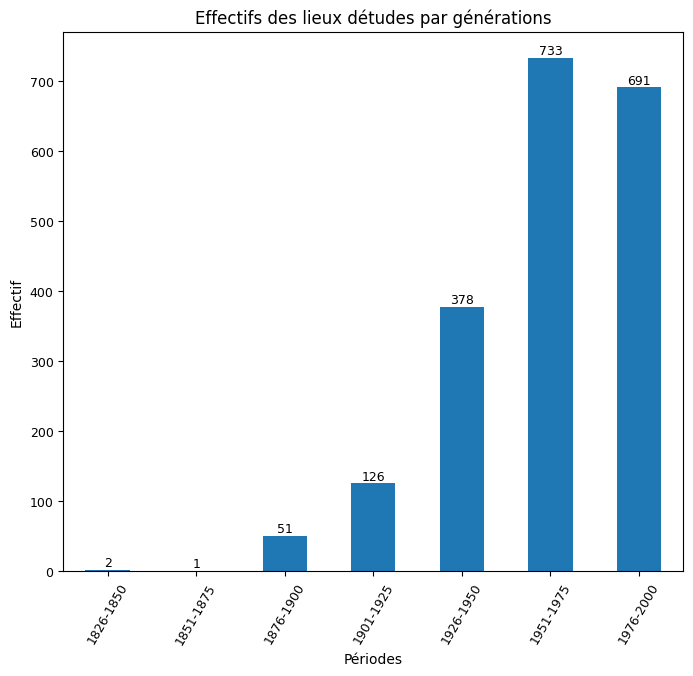

In [107]:
ax = df_all.groupby(by='generations', observed=True).size().plot(kind='bar',
                                            rot=60, fontsize=9, figsize=(8,7))
ax.bar_label(ax.containers[0], fontsize=9)
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Effectifs des lieux détudes par générations')
plt.show()

In [108]:
### Créer une nouvelle table contenant le DataFrame
# Si on tente de la recréer, alor qu'elle existe déjà,
# un message d'erreur est renvoyé
try:
    l = df_all[['generations', 'placeUri', 'placeLabel', 'geo_coord']]\
             .to_sql(name='wdt_generations_study_place', con=cn, if_exists='fail')
except Exception as e:
    print('Erreur: ',  e)

Erreur:  Table 'wdt_generations_study_place' already exists.


## Grouper et compter

On passe par la base de données parce que c'est plus simple qu'utiliser directement Pandas.

Noter que désormais ce sont les naissances (regroupées en périodes), et leur effectif, qui sont la variable étudiée

In [109]:
q1 = """
SELECT generations, placeLabel, geo_coord, COUNT(*) as effectif
FROM wdt_generations_study_place
GROUP BY generations, placeUri, placeLabel, geo_coord
"""
### Préparer les données à afficher
cur = cn.cursor()
l = cur.execute(q1).fetchall()
print(len(l))
l[:2]

1346


[('1826-1850',
  'Academy of Fine Arts, Munich',
  'Point(11.580312391 48.15319592)',
  1),
 ('1826-1850', 'Vilnius University', 'Point(25.287222222 54.6825)', 1)]

In [110]:
### Préparation des données à afficher dans Plotly Express
# ici on utilisé les coordonnées géographiques
df_gen_gr = pd.DataFrame(l, columns=['periode', 'lieu', 'geo_coord', 'eff'])
df_gen_gr.geo_coord = df_gen_gr.geo_coord.apply(lambda x: x.replace('Point(', '')\
                                .replace(')',''))
df_gen_gr['long'] = df_gen_gr.geo_coord\
    .apply(lambda x: round(float((x.split(' ')[0])), 4))
df_gen_gr['lat'] = df_gen_gr.geo_coord\
    .apply(lambda x: round(float((x.split(' ')[1])), 4))

df_gen_gr.head()

,periode,lieu,geo_coord,eff,long,lat
0,1826-1850,"Academy of Fine Arts, Munich",11.580312391 48.15319592,1,11.5803,48.1532
1,1826-1850,Vilnius University,25.287222222 54.6825,1,25.2872,54.6825
2,1851-1875,École normale supérieure de jeunes filles,2.33131 48.8224,1,2.3313,48.8224
3,1876-1900,Althin's School of Painting,18.084953333 59.334046666,1,18.0850,59.3340
4,1876-1900,Howard University,-77.02 38.921666666,1,-77.0200,38.9217


In [111]:
### Création de la carte interactive
# https://plotly.com/python/animations/
# https://plotly.com/python/scatter-plots-on-maps/

# np.log(s) * 1000
size = [s if s != 0 else 0 for s in df_gen_gr.eff]

fig = px.scatter_geo(
    df_gen_gr,
    lat="lat",
    lon="long",
    size=size,
    hover_name = "lieu",
    animation_frame="periode",
    width=1400, height=600,
    color_discrete_sequence=['red'],
    title="Evolution des lieux détudes"
).update_layout(
        margin={"l": 0, "r": 20, "t": 30, "b": 0}
)

# On peut ici augmenter la durée des étapes
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1500

### Noter qu'on enregistre l'image afin de pouvoir l'ouvrir dans un navigateur
# et l'inspecter sans exécuter le code Python du carnet

# Vérification et création du répertoire 'images' si nécessaire
os.makedirs('images', exist_ok=True)

# Chemin de l'image à enregistrer
f_address = "images/study_places_points.html"
fig.write_html(f_address)

#fig.show()


Grouper et compter les institutions d'études par État contemporain

In [112]:
### Polygones des États contemporains
print(len(world))
world.head()

177


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [113]:
world_s = world[['name','geometry']].copy(deep=True)
world_s

,name,geometry
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,W. Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...
172,Serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Montenegro,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,Kosovo,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Trinidad and Tobago,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [114]:
### Transformer les coordonnées géogr. en points
df_gen_gr_gdf = gpd.GeoDataFrame(
    df_gen_gr[['periode', 'lieu', 'eff']],\
    geometry=gpd.points_from_xy(df_gen_gr.long, df_gen_gr.lat), crs="EPSG:4326"
)

df_gen_gr_gdf.head(3)

,periode,lieu,eff,geometry
0,1826-1850,"Academy of Fine Arts, Munich",1,POINT (11.58030 48.15320)
1,1826-1850,Vilnius University,1,POINT (25.28720 54.68250)
2,1851-1875,École normale supérieure de jeunes filles,1,POINT (2.33130 48.82240)


In [115]:
### Vérification
df_gen_gr_gdf.loc[df_gen_gr_gdf['lieu']=='Vilnius University']

,periode,lieu,eff,geometry
1,1826-1850,Vilnius University,1,POINT (25.28720 54.68250)


## Préparation de la fonction qui va créer les données à afficher

In [116]:
# https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html
# https://stackoverflow.com/questions/69644523/count-points-in-polygon-and-write-result-to-geodataframe


dfa = world_s.copy(deep=True)
dfb = df_gen_gr_gdf[df_gen_gr_gdf.periode == '1926-1950']

### jointure spatiale
dfc =  gpd.sjoin(dfb, dfa).groupby("name").sum(numeric_only=True)
dfa = dfa.join(dfc, on='name', how="left")
dfa.eff.fillna(value=0, inplace=True)
dfa['eff'] = dfa['eff'].astype(int)

dfa = dfa.assign(periode = '1926-1950')

dfa[dfa.eff > 0].sort_values(by='eff', ascending=False).head()

,name,geometry,eff,index_right,periode
4,United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",129,372.0,1926-1950
143,United Kingdom,"MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...",64,6292.0,1926-1950
155,Japan,"MULTIPOLYGON (((141.88460 39.18086, 140.95949 ...",36,3720.0,1926-1950
43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",36,645.0,1926-1950
141,Italy,"MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...",12,1269.0,1926-1950


In [117]:
### Transformer en json pour afficher dans Plotly Express
countries_polygons = dfa[['name', 'geometry']]
countries_polygons.index = countries_polygons['name']
countries_polygons = countries_polygons.drop(['name'], axis=1)
countries_polygons_json = json.loads(countries_polygons.to_json())

In [118]:
### Représenter la densité de naissances de créateurs de mode par lieux d'études
# uniquement pour une période donnée
# https://plotly.com/python/animations/
# https://plotly.com/python-api-reference/generated/plotly.express.choropleth_mapbox.html
# https://medium.com/@lucas_bromerchenkel/choropleth-maps-with-time-sliders-using-plotly-df6e19e5f90c

# np.log(s) * 1000
size = [s if s != 0 else 0 for s in dfa.eff]

fig = px.choropleth_mapbox(
    dfa,
    geojson=countries_polygons_json,
    locations="name",
    color="eff",
    mapbox_style='white-bg',
    zoom=1,
    color_continuous_scale='blues',
    ### valeur 20 définie en fonction de la distribution par pays
    # expérimenter en changeant la valeur
    range_color=(1, 25),
    width=1000, height=600,
    title="Densité de naissance de créateurs de mode par lieux détudes"
)

# fig.show()

# Chemin de l'image à enregistrer
f_address = "density_map.html"

# Enregistrez l'image au format HTML
fig.write_html(f_address)

In [119]:
### Créer la liste des périodes
lp = df_gen_gr.groupby(by='periode').size().index.to_list()
lp

['1826-1850',
 '1851-1875',
 '1876-1900',
 '1901-1925',
 '1926-1950',
 '1951-1975',
 '1976-2000']

In [120]:
### Préparer les données, un DataFrame avec jointure spatiale
# par période
frames=[]
for e in lp:

    dfa = world_s.copy(deep=True)
    dfb = df_gen_gr_gdf[df_gen_gr_gdf.periode == e]

    ### jointure spatiale
    dfc =  gpd.sjoin(dfb, dfa).groupby("name").sum(numeric_only=True)
    dfa = dfa.join(dfc, on='name', how="left")
    dfa.eff.fillna(value=0, inplace=True)
    dfa['eff'] = dfa['eff'].astype(int)

    dfa = dfa.assign(periode = e)

    frames.append(dfa)


### Concaténation des DataFrames
df_result = pd.concat(frames)
df_result=df_result.reset_index()
df_result.tail()

,index,name,geometry,eff,index_right,periode
1234,172,Serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",3,344.0,1976-2000
1235,173,Montenegro,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",0,NaN,1976-2000
1236,174,Kosovo,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",0,NaN,1976-2000
1237,175,Trinidad and Tobago,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",0,NaN,1976-2000
1238,176,S. Sudan,"POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...",0,NaN,1976-2000


In [121]:
### inspection des données pour un pays
df_result[df_result.name=='France']

,index,name,geometry,eff,index_right,periode
43,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",0,NaN,1826-1850
220,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",1,43.0,1851-1875
397,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",9,215.0,1876-1900
574,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",9,301.0,1901-1925
751,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",36,645.0,1926-1950
928,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",33,817.0,1951-1975
1105,43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",23,559.0,1976-2000


In [122]:
### Transformer en json pour affichage dans Plotly
countries_polygons = df_result[['name', 'geometry']]
countries_polygons.index = countries_polygons['name']
countries_polygons = countries_polygons.drop(['name'], axis=1)
countries_polygons_json = json.loads(countries_polygons.to_json())

In [123]:
### Représenter la densité de naissances de créateur de mode par pays du lieu d'études
# carte interactive.
# Noter que l'exécution peutprendre quelques minutes

# https://plotly.com/python/animations/
# https://plotly.com/python-api-reference/generated/plotly.express.choropleth_mapbox.html
# https://medium.com/@lucas_bromerchenkel/choropleth-maps-with-time-sliders-using-plotly-df6e19e5f90c

# np.log(s) * 1000
size = [s if s != 0 else 0 for s in df_result.eff]

fig = px.choropleth_mapbox(
    df_result,
    geojson=countries_polygons_json,
    locations="name",
    color="eff",
    mapbox_style='white-bg',
    zoom=1,
    color_continuous_scale='blues',
    ### valeur 20 définie en fonction de la distribution par pays
    # expérimenter en changeant la valeur
    range_color=(1, 20),
    animation_frame="periode",
    width=1000, height=600,
    title="Evolution des lieux détudes"
).update_layout(
    #mapbox={"style": "carto-positron", "zoom":10},
    margin={"l": 0, "r": 0, "t": 30, "b": 0}
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000

### Noter qu'on enregistre l'image afin de pouvoir l'ouvrir dans un navigateur
# et l'inspecter sans exécuter le code Python du carnet
f_address = "images/study_places_choropleth.html"
fig.write_html(f_address)

# fig.show()